# Rede Neural - Classificação de Comportamento de Bezerros

Este notebook implementa uma Rede Neural simples para classificação de comportamentos de bezerros usando os dados do AcTBeCalf.

**Divisão dos dados:**
- Treino: 24 bezerros específicos
- Validação: 2 bezerros específicos  
- Teste: 4 bezerros específicos
- **Apenas as 8 classes com mais amostras**

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("Bibliotecas importadas com sucesso!")

PyTorch version: 2.9.1+cu128
CUDA disponível: True
GPU: NVIDIA GeForce GTX 1650
Bibliotecas importadas com sucesso!


## 1. Carregamento e Preparação dos Dados

In [2]:
# Carregar dados
print("Carregando AcTBeCalf.parquet...")
df_pl = pl.read_parquet('AcTBeCalf.parquet')

# Converter para Pandas para facilitar manipulação
df = df_pl.to_pandas()

print(f"✅ Dados carregados: {len(df):,} amostras")
print(f"📊 Colunas: {list(df.columns)}")
print(f"🐄 Bezerros únicos: {df['calfId'].nunique()}")
print(f"📋 Comportamentos únicos: {df['behaviour'].nunique()}")

# Divisão específica de bezerros conforme solicitado
train_calves = ['1302', '1303', '1306', '1308', '1312', '1314', '1328', '1329',
                '1335', '1336', '1343', '1353', '1357', '1372', '1398', '1408',
                '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455']

val_calves = ['1320', '1405']

test_calves = ['1319', '1333', '1351', '1403']

print(f"\n📊 Divisão de bezerros:")
print(f"  Treino: {len(train_calves)} bezerros")
print(f"  Validação: {len(val_calves)} bezerros")
print(f"  Teste: {len(test_calves)} bezerros")

Carregando AcTBeCalf.parquet...
✅ Dados carregados: 2,467,162 amostras
📊 Colunas: ['dateTime', 'calfId', 'accX', 'accY', 'accZ', 'behaviour', 'segId']
🐄 Bezerros únicos: 30
📋 Comportamentos únicos: 50

📊 Divisão de bezerros:
  Treino: 24 bezerros
  Validação: 2 bezerros
  Teste: 4 bezerros


In [3]:
# Identificar e filtrar as 8 classes com mais amostras
print("🔍 Identificando as 8 classes com mais amostras...")
print("=" * 60)

# Contar amostras por classe no dataset completo
class_counts = df['behaviour'].value_counts()
print(f"\n📊 Total de classes no dataset: {len(class_counts)}")
print(f"\n🔝 Top 10 classes por quantidade:")
for i, (behavior, count) in enumerate(class_counts.head(10).items(), 1):
    print(f"  {i}. {behavior}: {count:,} amostras ({count/len(df)*100:.2f}%)")

# Selecionar as 8 classes com mais amostras
top_8_classes = class_counts.head(8).index.tolist()

print(f"\n✅ 8 classes selecionadas:")
for i, behavior in enumerate(top_8_classes, 1):
    count = class_counts[behavior]
    print(f"  {i}. {behavior}: {count:,} amostras ({count/len(df)*100:.2f}%)")

# Filtrar dataset para conter apenas as 8 classes
print(f"\n📉 Filtrando dataset...")
df_original_size = len(df)
df = df[df['behaviour'].isin(top_8_classes)].copy()

print(f"  Original: {df_original_size:,} amostras")
print(f"  Filtrado (8 classes): {len(df):,} amostras")
print(f"  Redução: {(1 - len(df)/df_original_size)*100:.2f}%")

print(f"\n✅ Dataset atualizado com apenas as 8 classes principais!")

🔍 Identificando as 8 classes com mais amostras...

📊 Total de classes no dataset: 50

🔝 Top 10 classes por quantidade:
  1. lying: 965,184 amostras (39.12%)
  2. drinking_milk: 217,075 amostras (8.80%)
  3. standing: 188,908 amostras (7.66%)
  4. eating_concentrates: 146,067 amostras (5.92%)
  5. sniff: 134,768 amostras (5.46%)
  6. eating_bedding: 129,119 amostras (5.23%)
  7. oral_manipulation_of_pen: 118,210 amostras (4.79%)
  8. grooming: 114,181 amostras (4.63%)
  9. running: 83,345 amostras (3.38%)
  10. eating_forage: 80,428 amostras (3.26%)

✅ 8 classes selecionadas:
  1. lying: 965,184 amostras (39.12%)
  2. drinking_milk: 217,075 amostras (8.80%)
  3. standing: 188,908 amostras (7.66%)
  4. eating_concentrates: 146,067 amostras (5.92%)
  5. sniff: 134,768 amostras (5.46%)
  6. eating_bedding: 129,119 amostras (5.23%)
  7. oral_manipulation_of_pen: 118,210 amostras (4.79%)
  8. grooming: 114,181 amostras (4.63%)

📉 Filtrando dataset...
  Original: 2,467,162 amostras
  Filtrado

In [4]:
# Preparar features e labels
feature_columns = ['accX', 'accY', 'accZ']
X = df[feature_columns].values
y = df['behaviour'].values

# Criar mapeamento de labels para inteiros
unique_labels = sorted(df['behaviour'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}

y_encoded = np.array([label_to_int[label] for label in y])

print(f"📊 Shape das features: {X.shape}")
print(f"📋 Número de classes: {len(unique_labels)}")
print(f"🏷️ Classes: {unique_labels}")

# Criar divisões baseadas nos bezerros
train_mask = df['calfId'].isin(train_calves)
val_mask = df['calfId'].isin(val_calves)
test_mask = df['calfId'].isin(test_calves)

X_train = X[train_mask]
y_train = y_encoded[train_mask]

X_val = X[val_mask]
y_val = y_encoded[val_mask]

X_test = X[test_mask]
y_test = y_encoded[test_mask]

print(f"\n📊 Tamanho dos conjuntos:")
print(f"  Treino: {X_train.shape[0]:,} amostras")
print(f"  Validação: {X_val.shape[0]:,} amostras")
print(f"  Teste: {X_test.shape[0]:,} amostras")

📊 Shape das features: (2013512, 3)
📋 Número de classes: 8
🏷️ Classes: ['drinking_milk', 'eating_bedding', 'eating_concentrates', 'grooming', 'lying', 'oral_manipulation_of_pen', 'sniff', 'standing']

📊 Tamanho dos conjuntos:
  Treino: 1,489,445 amostras
  Validação: 187,810 amostras
  Teste: 336,257 amostras


In [5]:
# Normalizar os dados
print("🔧 Normalizando dados com StandardScaler...")

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

print(f"✅ Dados normalizados!")
print(f"\n📊 Estatísticas dos dados de treino normalizados:")
print(f"  Média: {X_train_normalized.mean(axis=0)}")
print(f"  Desvio padrão: {X_train_normalized.std(axis=0)}")

# Converter para tensores PyTorch
num_classes = len(unique_labels)

# Definir device (GPU se disponível, senão CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Usando device: {device}")

# Converter dados para tensores
X_train_tensor = torch.FloatTensor(X_train_normalized).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)

X_val_tensor = torch.FloatTensor(X_val_normalized).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)

X_test_tensor = torch.FloatTensor(X_test_normalized).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print(f"\n🔢 Dados convertidos para tensores PyTorch")
print(f"  Shape X_train: {X_train_tensor.shape}")
print(f"  Shape y_train: {y_train_tensor.shape}")
print(f"  Número de classes: {num_classes}")

🔧 Normalizando dados com StandardScaler...
✅ Dados normalizados!

📊 Estatísticas dos dados de treino normalizados:
  Média: [ 2.2832774e-05  2.9938872e-05 -9.2768460e-05]
  Desvio padrão: [1.0000163  0.9995846  0.99866027]

🖥️ Usando device: cuda

🔢 Dados convertidos para tensores PyTorch
  Shape X_train: torch.Size([1489445, 3])
  Shape y_train: torch.Size([1489445])
  Número de classes: 8


## 2. Construção da Rede Neural

In [6]:
# Definir arquitetura da Rede Neural com PyTorch
print("🏗️ Construindo Rede Neural com PyTorch...")

class BehaviorClassifier(nn.Module):
    def __init__(self, input_size=3, num_classes=8):
        super(BehaviorClassifier, self).__init__()

        self.network = nn.Sequential(
            # Camada 1
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Camada 2
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Camada 3
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Camada de saída
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Criar modelo
model = BehaviorClassifier(input_size=3, num_classes=num_classes).to(device)

# Definir loss e optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([
    1.0,  # drinking_milk
    2.0,  # eating_bedding
    3.0,  # eating_concentrates
    4.0,  # grooming
    0.3,  # lying (classe majoritária - peso menor)
    2.5,  # oral_manipulation_of_pen
    2.8,  # sniff
    2.2   # standing
]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Scheduler para reduzir learning rate após 20 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Contar parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n📋 Arquitetura do modelo:")
print(model)
print(f"\n✅ Modelo criado com sucesso!")
print(f"   Total de parâmetros: {total_params:,}")
print(f"   Parâmetros treináveis: {trainable_params:,}")

🏗️ Construindo Rede Neural com PyTorch...

📋 Arquitetura do modelo:
BehaviorClassifier(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=8, bias=True)
  )
)

✅ Modelo criado com sucesso!
   Total de parâmetros: 6,760
   Parâmetros treináveis: 6,760


## 3. Treinamento

In [7]:
# Função de treinamento
def train_epoch(model, criterion, optimizer, X, y):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # Calcular acurácia
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y).sum().item()
    accuracy = correct / y.size(0)

    return loss.item(), accuracy

# Função de validação
def validate(model, criterion, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, y)

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)

    return loss.item(), accuracy

# Treinamento
print("🎯 Iniciando treinamento...")
print("=" * 60)

num_epochs = 1000
patience = 50
best_val_loss = float('inf')
patience_counter = 0

# Histórico
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    # Treinar
    train_loss, train_acc = train_epoch(model, criterion, optimizer, X_train_tensor, y_train_tensor)

    # Validar
    val_loss, val_acc = validate(model, criterion, X_val_tensor, y_val_tensor)

    # Salvar histórico
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print progresso a cada 5 épocas
    if (epoch + 1) % 5 == 0:
        print(f"Época [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Salvar melhor modelo
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠️ Early stopping na época {epoch+1}")
            model.load_state_dict(best_model_state)
            break

print("\n✅ Treinamento concluído!")
print(f"📊 Total de épocas: {len(history['train_loss'])}")
print(f"🎯 Melhor val_loss: {best_val_loss:.4f}")

🎯 Iniciando treinamento...
Época [5/1000] - Train Loss: 2.0862, Train Acc: 0.1085 | Val Loss: 2.0820, Val Acc: 0.2481
Época [10/1000] - Train Loss: 2.0769, Train Acc: 0.1047 | Val Loss: 2.0736, Val Acc: 0.3475
Época [15/1000] - Train Loss: 2.0685, Train Acc: 0.1028 | Val Loss: 2.0677, Val Acc: 0.3868
Época [20/1000] - Train Loss: 2.0606, Train Acc: 0.1018 | Val Loss: 2.0608, Val Acc: 0.3973
Época [25/1000] - Train Loss: 2.0529, Train Acc: 0.1025 | Val Loss: 2.0522, Val Acc: 0.3959
Época [30/1000] - Train Loss: 2.0442, Train Acc: 0.1055 | Val Loss: 2.0429, Val Acc: 0.3907
Época [35/1000] - Train Loss: 2.0362, Train Acc: 0.1087 | Val Loss: 2.0346, Val Acc: 0.3619
Época [40/1000] - Train Loss: 2.0272, Train Acc: 0.1143 | Val Loss: 2.0282, Val Acc: 0.3344
Época [45/1000] - Train Loss: 2.0181, Train Acc: 0.1221 | Val Loss: 2.0261, Val Acc: 0.3648
Época [50/1000] - Train Loss: 2.0095, Train Acc: 0.1326 | Val Loss: 2.0336, Val Acc: 0.4015
Época [55/1000] - Train Loss: 2.0003, Train Acc: 0.145

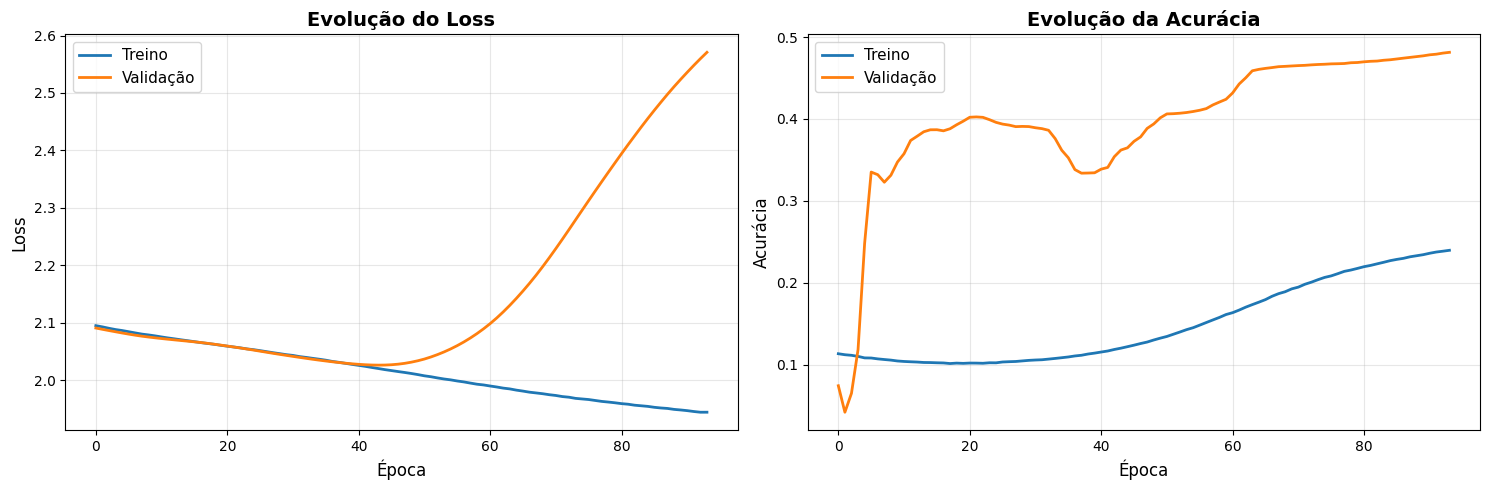

📊 Total de épocas treinadas: 94


In [19]:
# Visualizar histórico de treinamento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Loss
axes[0].plot(history['train_loss'], label='Treino', linewidth=2)
axes[0].plot(history['val_loss'], label='Validação', linewidth=2)
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Evolução do Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Gráfico de Acurácia
axes[1].plot(history['train_acc'], label='Treino', linewidth=2)
axes[1].plot(history['val_acc'], label='Validação', linewidth=2)
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('Acurácia', fontsize=12)
axes[1].set_title('Evolução da Acurácia', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Total de épocas treinadas: {len(history['train_loss'])}")

## 4. Avaliação

In [9]:
# Fazer predições
print("🔮 Fazendo predições...")

model.eval()
with torch.no_grad():
    # Predições de treino
    train_outputs = model(X_train_tensor)
    train_probs = torch.softmax(train_outputs, dim=1)
    y_train_pred = torch.argmax(train_outputs, dim=1).cpu().numpy()
    y_train_pred_proba = train_probs.cpu().numpy()

    # Predições de validação
    val_outputs = model(X_val_tensor)
    val_probs = torch.softmax(val_outputs, dim=1)
    y_val_pred = torch.argmax(val_outputs, dim=1).cpu().numpy()
    y_val_pred_proba = val_probs.cpu().numpy()

    # Predições de teste
    test_outputs = model(X_test_tensor)
    test_probs = torch.softmax(test_outputs, dim=1)
    y_test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()
    y_test_pred_proba = test_probs.cpu().numpy()

# Calcular acurácias
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n🎯 Resultados:")
print(f"  Acurácia Treino: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Acurácia Validação: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Acurácia Teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

🔮 Fazendo predições...

🎯 Resultados:
  Acurácia Treino: 0.2615 (26.15%)
  Acurácia Validação: 0.4814 (48.14%)
  Acurácia Teste: 0.2857 (28.57%)


In [10]:
# Relatório de classificação para conjunto de teste
print("📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE TESTE")
print("=" * 60)

behavior_names = [int_to_label[i] for i in range(num_classes)]

# Relatório detalhado
report = classification_report(
    y_test,
    y_test_pred,
    target_names=behavior_names,
    digits=4
)
print(report)

print(f"\n📈 RESUMO FINAL:")
print("=" * 30)
print(f"  🎯 Acurácia Final (Teste): {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  🧠 Arquitetura: MLP (Multi-Layer Perceptron)")
print(f"  📊 Total de amostras teste: {len(y_test):,}")
print(f"  📋 Total de classes: {len(behavior_names)}")

📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE TESTE
                          precision    recall  f1-score   support

           drinking_milk     0.0000    0.0000    0.0000     21066
          eating_bedding     0.0000    0.0000    0.0000     25964
     eating_concentrates     0.0016    0.0512    0.0030      3146
                grooming     0.0643    0.3025    0.1060      4591
                   lying     0.8568    0.3352    0.4819    245131
oral_manipulation_of_pen     0.0437    0.2657    0.0751     10388
                   sniff     0.2698    0.2350    0.2512     13421
                standing     0.1556    0.5136    0.2388     12550

                accuracy                         0.2857    336257
               macro avg     0.1740    0.2129    0.1445    336257
            weighted avg     0.6435    0.2857    0.3740    336257


📈 RESUMO FINAL:
  🎯 Acurácia Final (Teste): 0.2857 (28.57%)
  🧠 Arquitetura: MLP (Multi-Layer Perceptron)
  📊 Total de amostras teste: 336,257
  📋 Total de

/home/gustavo/codigos/Calf-Behavior-Classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gustavo/codigos/Calf-Behavior-Classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gustavo/codigos/Calf-Behavior-Classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

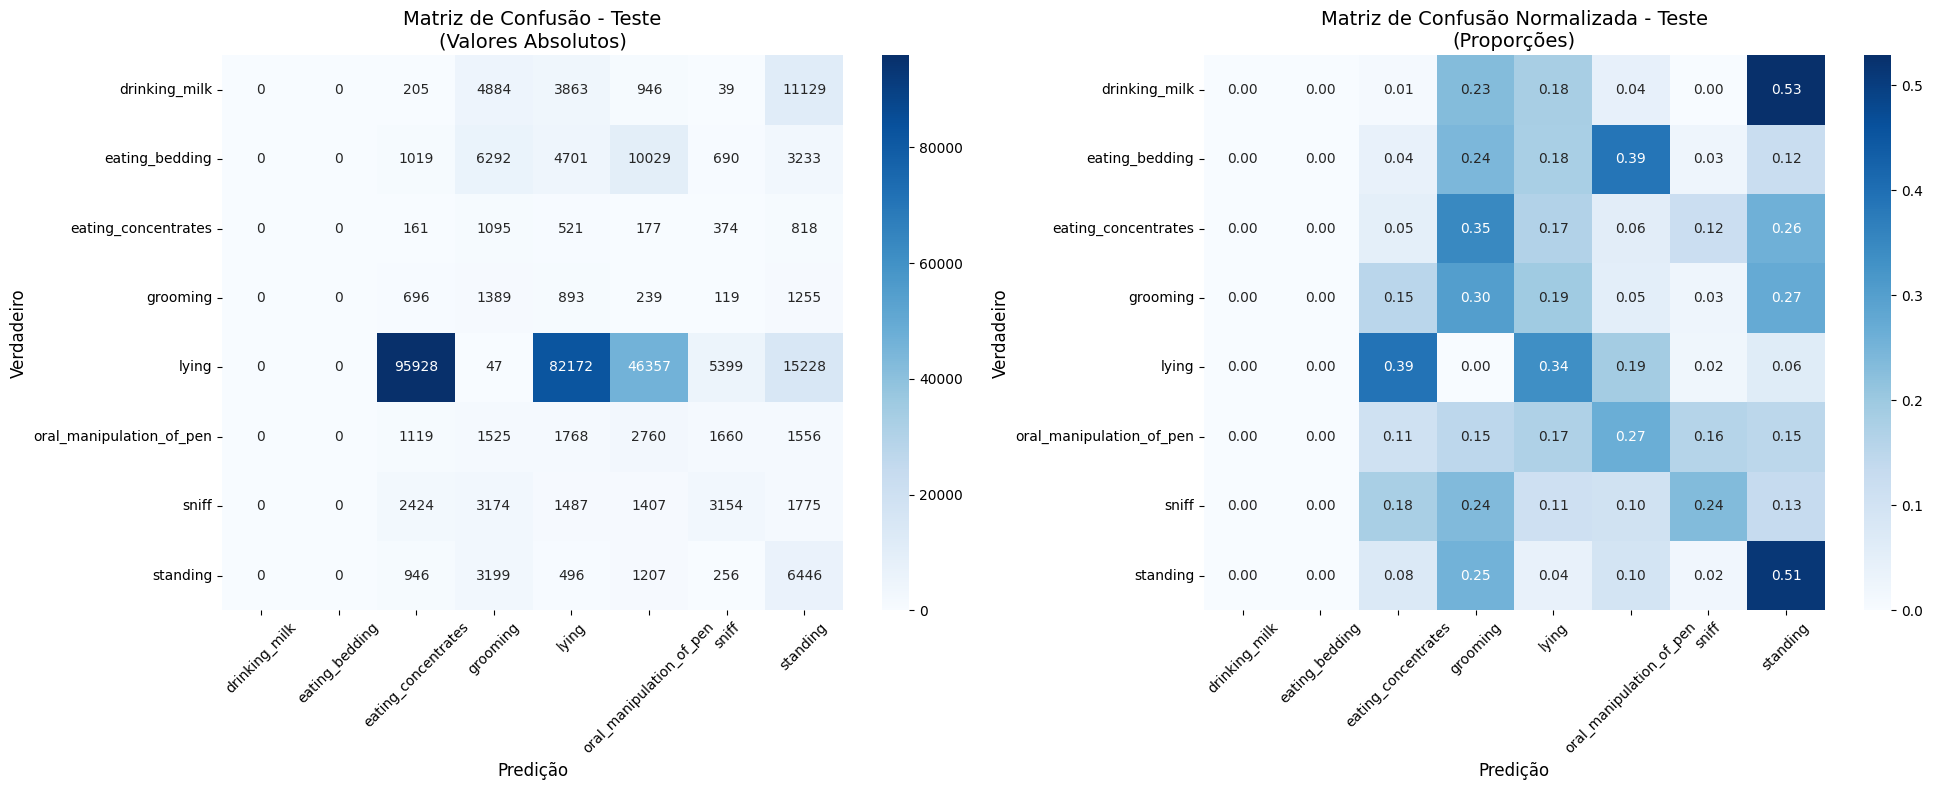

📊 Matrizes de Confusão geradas para o conjunto de teste (8 classes)


In [11]:
# Matriz de confusão - Teste
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Matriz de confusão absoluta
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=behavior_names,
           yticklabels=behavior_names,
           ax=axes[0])
axes[0].set_title('Matriz de Confusão - Teste\n(Valores Absolutos)', fontsize=14)
axes[0].set_xlabel('Predição', fontsize=12)
axes[0].set_ylabel('Verdadeiro', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Matriz de confusão normalizada
cm_test_normalized = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_test_normalized,
           annot=True,
           fmt='.2f',
           cmap='Blues',
           xticklabels=behavior_names,
           yticklabels=behavior_names,
           ax=axes[1])
axes[1].set_title('Matriz de Confusão Normalizada - Teste\n(Proporções)', fontsize=14)
axes[1].set_xlabel('Predição', fontsize=12)
axes[1].set_ylabel('Verdadeiro', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"📊 Matrizes de Confusão geradas para o conjunto de teste ({len(behavior_names)} classes)")

## 5. Avaliação do Conjunto de Validação

In [12]:
# Relatório de classificação para conjunto de validação
print("📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE VALIDAÇÃO")
print("=" * 60)

# Relatório detalhado
report_val = classification_report(
    y_val,
    y_val_pred,
    target_names=behavior_names,
    digits=4
)
print(report_val)

print(f"\n📈 RESUMO DO CONJUNTO DE VALIDAÇÃO:")
print("=" * 40)
print(f"  🎯 Acurácia: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  📊 Total de amostras: {len(y_val):,}")
print(f"  📋 Total de classes: {len(behavior_names)}")

📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE VALIDAÇÃO
                          precision    recall  f1-score   support

           drinking_milk     0.0000    0.0000    0.0000     13591
          eating_bedding     0.0000    0.0000    0.0000      6035
     eating_concentrates     0.4625    0.2315    0.3085     30648
                grooming     0.2791    0.2200    0.2461     10227
                   lying     0.5667    0.8930    0.6934     78378
oral_manipulation_of_pen     0.4456    0.3189    0.3718     14436
                   sniff     0.7096    0.0681    0.1242     10269
                standing     0.1948    0.2380    0.2143     24226

                accuracy                         0.4814    187810
               macro avg     0.3323    0.2462    0.2448    187810
            weighted avg     0.4254    0.4814    0.4161    187810


📈 RESUMO DO CONJUNTO DE VALIDAÇÃO:
  🎯 Acurácia: 0.4814 (48.14%)
  📊 Total de amostras: 187,810
  📋 Total de classes: 8


/home/gustavo/codigos/Calf-Behavior-Classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gustavo/codigos/Calf-Behavior-Classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/gustavo/codigos/Calf-Behavior-Classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

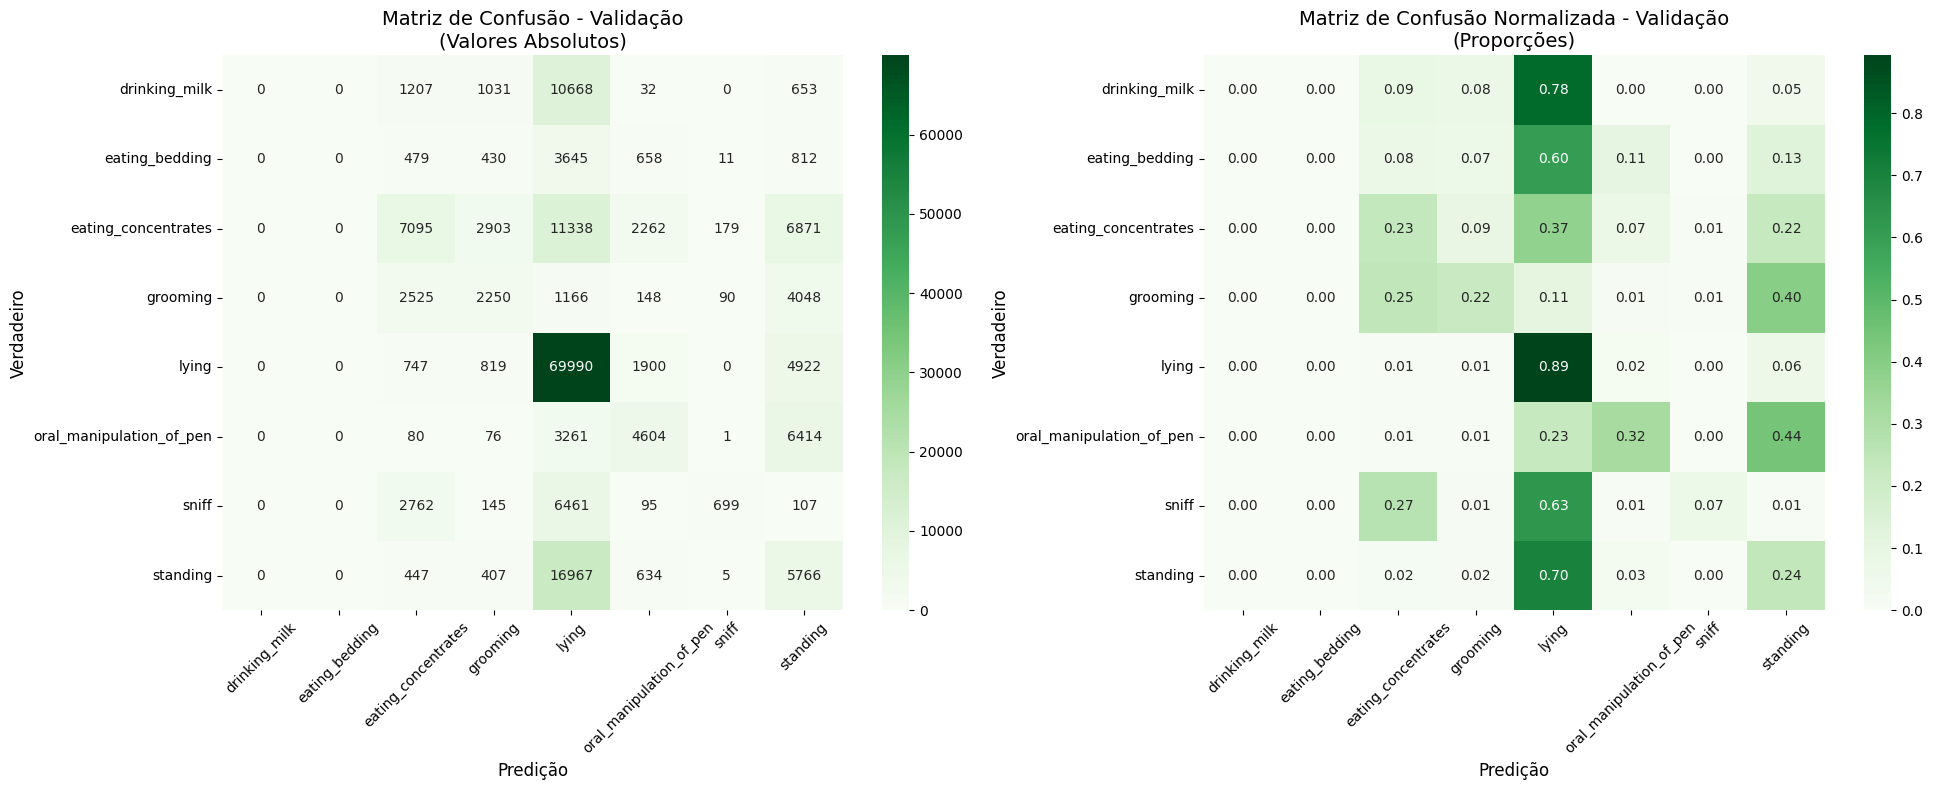

📊 Matrizes de Confusão geradas para o conjunto de validação (8 classes)


In [13]:
# Matriz de confusão - Validação
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Matriz de confusão absoluta
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val,
           annot=True,
           fmt='d',
           cmap='Greens',
           xticklabels=behavior_names,
           yticklabels=behavior_names,
           ax=axes[0])
axes[0].set_title('Matriz de Confusão - Validação\n(Valores Absolutos)', fontsize=14)
axes[0].set_xlabel('Predição', fontsize=12)
axes[0].set_ylabel('Verdadeiro', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Matriz de confusão normalizada
cm_val_normalized = confusion_matrix(y_val, y_val_pred, normalize='true')
sns.heatmap(cm_val_normalized,
           annot=True,
           fmt='.2f',
           cmap='Greens',
           xticklabels=behavior_names,
           yticklabels=behavior_names,
           ax=axes[1])
axes[1].set_title('Matriz de Confusão Normalizada - Validação\n(Proporções)', fontsize=14)
axes[1].set_xlabel('Predição', fontsize=12)
axes[1].set_ylabel('Verdadeiro', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"📊 Matrizes de Confusão geradas para o conjunto de validação ({len(behavior_names)} classes)")

📊 COMPARAÇÃO: TESTE vs VALIDAÇÃO
 Conjunto  Acurácia  Amostras  Classes
    Teste  0.285740    336257        8
Validação  0.481359    187810        8


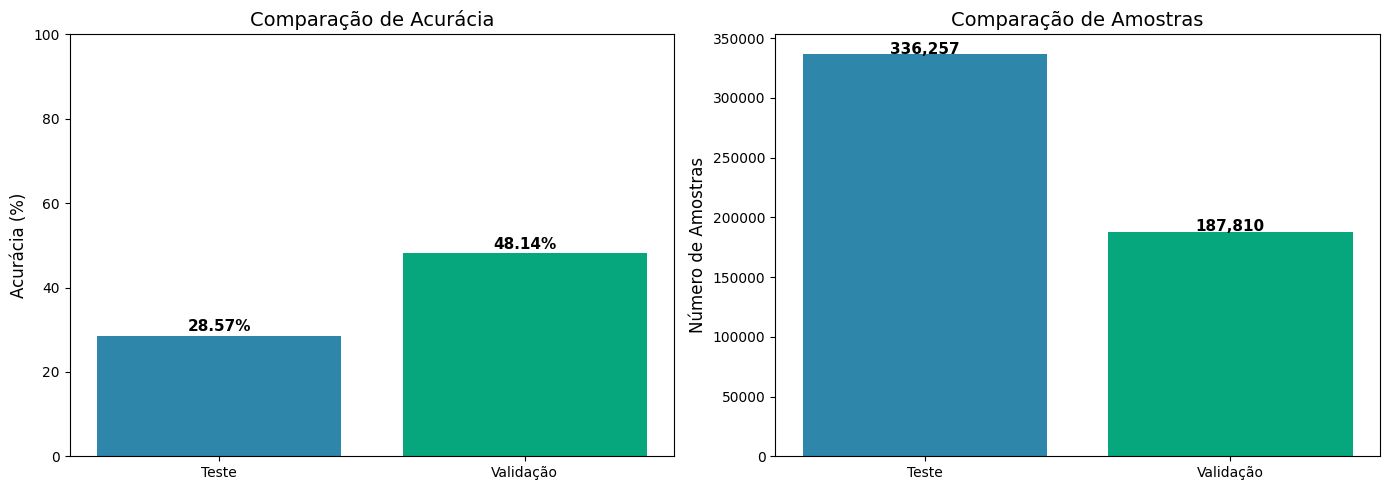


✅ Análise de validação concluída!
💡 Diferença de acurácia: 19.56%


In [14]:
# Comparação entre Teste e Validação
print("📊 COMPARAÇÃO: TESTE vs VALIDAÇÃO")
print("=" * 60)

# Criar DataFrame de comparação
comparison_data = {
    'Conjunto': ['Teste', 'Validação'],
    'Acurácia': [test_accuracy, val_accuracy],
    'Amostras': [len(y_test), len(y_val)],
    'Classes': [len(behavior_names), len(behavior_names)]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualização da comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras - Acurácia
axes[0].bar(['Teste', 'Validação'],
           [test_accuracy*100, val_accuracy*100],
           color=['#2E86AB', '#06A77D'])
axes[0].set_ylabel('Acurácia (%)', fontsize=12)
axes[0].set_title('Comparação de Acurácia', fontsize=14)
axes[0].set_ylim([0, 100])
for i, v in enumerate([test_accuracy*100, val_accuracy*100]):
    axes[0].text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

# Gráfico de barras - Número de amostras
axes[1].bar(['Teste', 'Validação'],
           [len(y_test), len(y_val)],
           color=['#2E86AB', '#06A77D'])
axes[1].set_ylabel('Número de Amostras', fontsize=12)
axes[1].set_title('Comparação de Amostras', fontsize=14)
for i, v in enumerate([len(y_test), len(y_val)]):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Análise de validação concluída!")
print(f"💡 Diferença de acurácia: {abs(test_accuracy - val_accuracy)*100:.2f}%")

## 6. Salvar Predições em CSV

In [15]:
# Salvar predições do conjunto de TESTE em CSV
print("💾 Salvando predições do conjunto de TESTE...")

predictions_test_df = pd.DataFrame({
    'timestamp': range(len(y_test)),
    'real': [int_to_label[label] for label in y_test],
    'predito': [int_to_label[label] for label in y_test_pred],
    'probabilidade': [y_test_pred_proba[i, y_test_pred[i]] for i in range(len(y_test_pred))]
})

predictions_test_df['acerto'] = predictions_test_df['real'] == predictions_test_df['predito']

predictions_test_df.to_csv('predicoes_nn_teste.csv', index=False)

print(f"✅ Arquivo salvo: predicoes_nn_teste.csv")
print(f"📊 Total de predições: {len(predictions_test_df):,}")
print(f"✔️ Acertos: {predictions_test_df['acerto'].sum():,} ({predictions_test_df['acerto'].sum()/len(predictions_test_df)*100:.2f}%)")
print(f"❌ Erros: {(~predictions_test_df['acerto']).sum():,} ({(~predictions_test_df['acerto']).sum()/len(predictions_test_df)*100:.2f}%)")

print(f"\n📋 Primeiras 10 linhas:")
print(predictions_test_df.head(10).to_string(index=False))

💾 Salvando predições do conjunto de TESTE...
✅ Arquivo salvo: predicoes_nn_teste.csv
📊 Total de predições: 336,257
✔️ Acertos: 96,082 (28.57%)
❌ Erros: 240,175 (71.43%)

📋 Primeiras 10 linhas:
 timestamp                real             predito  probabilidade  acerto
         0 eating_concentrates               sniff       0.242819   False
         1 eating_concentrates               sniff       0.242646   False
         2 eating_concentrates               sniff       0.235881   False
         3 eating_concentrates               sniff       0.247859   False
         4 eating_concentrates               sniff       0.247842   False
         5 eating_concentrates               sniff       0.244779   False
         6 eating_concentrates               sniff       0.244757   False
         7 eating_concentrates               sniff       0.244909   False
         8 eating_concentrates eating_concentrates       0.230193    True
         9 eating_concentrates               sniff       0.261697  

In [16]:
# Salvar predições do conjunto de VALIDAÇÃO em CSV
print("💾 Salvando predições do conjunto de VALIDAÇÃO...")

predictions_val_df = pd.DataFrame({
    'timestamp': range(len(y_val)),
    'real': [int_to_label[label] for label in y_val],
    'predito': [int_to_label[label] for label in y_val_pred],
    'probabilidade': [y_val_pred_proba[i, y_val_pred[i]] for i in range(len(y_val_pred))]
})

predictions_val_df['acerto'] = predictions_val_df['real'] == predictions_val_df['predito']

predictions_val_df.to_csv('predicoes_nn_validacao.csv', index=False)

print(f"✅ Arquivo salvo: predicoes_nn_validacao.csv")
print(f"📊 Total de predições: {len(predictions_val_df):,}")
print(f"✔️ Acertos: {predictions_val_df['acerto'].sum():,} ({predictions_val_df['acerto'].sum()/len(predictions_val_df)*100:.2f}%)")
print(f"❌ Erros: {(~predictions_val_df['acerto']).sum():,} ({(~predictions_val_df['acerto']).sum()/len(predictions_val_df)*100:.2f}%)")

print(f"\n📋 Primeiras 10 linhas:")
print(predictions_val_df.head(10).to_string(index=False))

💾 Salvando predições do conjunto de VALIDAÇÃO...
✅ Arquivo salvo: predicoes_nn_validacao.csv
📊 Total de predições: 187,810
✔️ Acertos: 90,404 (48.14%)
❌ Erros: 97,406 (51.86%)

📋 Primeiras 10 linhas:
 timestamp                real  predito  probabilidade  acerto
         0 eating_concentrates standing       0.199522   False
         1 eating_concentrates standing       0.181789   False
         2 eating_concentrates standing       0.176630   False
         3 eating_concentrates standing       0.199651   False
         4 eating_concentrates standing       0.160849   False
         5 eating_concentrates standing       0.162234   False
         6 eating_concentrates standing       0.202682   False
         7 eating_concentrates standing       0.174013   False
         8 eating_concentrates standing       0.160808   False
         9 eating_concentrates standing       0.209039   False


## 7. Salvar Modelo

In [17]:
# Salvar modelo treinado
print("💾 Salvando modelo PyTorch...")

import joblib
import json

# Salvar modelo PyTorch
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': num_classes,
    'input_size': 3
}, 'modelo_nn_comportamento.pth')
print("✅ Modelo salvo: modelo_nn_comportamento.pth")

# Salvar scaler
joblib.dump(scaler, 'scaler_nn.pkl')
print("✅ Scaler salvo: scaler_nn.pkl")

# Salvar mapeamento de labels
with open('label_mapping_nn.json', 'w') as f:
    json.dump({'label_to_int': label_to_int, 'int_to_label': int_to_label}, f, indent=2)
print("✅ Mapeamento de labels salvo: label_mapping_nn.json")

print("\n🎉 Tudo salvo com sucesso!")
print(f"\n📝 Para carregar o modelo:")
print("   checkpoint = torch.load('modelo_nn_comportamento.pth')")
print("   model.load_state_dict(checkpoint['model_state_dict'])")

💾 Salvando modelo PyTorch...
✅ Modelo salvo: modelo_nn_comportamento.pth
✅ Scaler salvo: scaler_nn.pkl
✅ Mapeamento de labels salvo: label_mapping_nn.json

🎉 Tudo salvo com sucesso!

📝 Para carregar o modelo:
   checkpoint = torch.load('modelo_nn_comportamento.pth')
   model.load_state_dict(checkpoint['model_state_dict'])


## 8. Liberar Memória da GPU

In [18]:
# Liberar memória da GPU
print("🧹 Limpando memória da GPU...")

# Mover tensores para CPU e deletar
del X_train_tensor, y_train_tensor
del X_val_tensor, y_val_tensor
del X_test_tensor, y_test_tensor

# Mover modelo para CPU
model = model.cpu()

# Limpar cache da GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    # Mostrar uso de memória
    allocated = torch.cuda.memory_allocated(0) / 1024**2  # MB
    reserved = torch.cuda.memory_reserved(0) / 1024**2    # MB

    print(f"✅ Memória GPU liberada!")
    print(f"📊 Memória alocada: {allocated:.2f} MB")
    print(f"📊 Memória reservada: {reserved:.2f} MB")
else:
    print("✅ Memória limpa (CPU mode)")

import gc
gc.collect()  # Coletar lixo do Python

print("🎉 Limpeza concluída!")

🧹 Limpando memória da GPU...
✅ Memória GPU liberada!
📊 Memória alocada: 140.78 MB
📊 Memória reservada: 432.00 MB
🎉 Limpeza concluída!
